<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/SciKitLearn_05_ProjFive_Supervised_Reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libs

In [35]:
!pip install -q import_ipynb

In [36]:
# utils
import os, sys, time, warnings
import scipy
import import_ipynb
import pandas as pd
import numpy as np
from scipy import stats, linalg
# colab
from google.colab import drive
# sklearn
import sklearn
from sklearn import preprocessing, metrics, linear_model, svm
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, WhiteKernel, RationalQuadratic, ExpSineSquared
# vis
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

In [37]:
print(sys.version)
print("sklearn: ", sklearn.__version__)

3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
sklearn:  1.5.2


## Setting

In [38]:
warnings.filterwarnings('ignore')

In [39]:
# mount google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# working directory
working_dir = '/content/drive/MyDrive/Jupyter Notebooks/'
os.chdir(working_dir)

In [41]:
# load MachineLearningUtils
from MachineLearningUtils import *

## Dataset

### CO2

In [42]:
path = 'Inputs/'
data = pd.read_csv(path + 'co2_mm_mlo.txt', header=0, delimiter='\s+')

In [43]:
summarize_columns(data)

,col_name,dtypes,missing,missing_percent,uniques,first_value,second_value,third_value
0,year,int64,0,0.0,66,1958.0000,1958.0000,1958.0000
1,month,int64,0,0.0,12,3.0000,4.0000,5.0000
2,decimal,float64,0,0.0,785,1958.2027,1958.2877,1958.3699
3,average,float64,0,0.0,763,315.7000,317.4500,317.5100
4,de-seasonalized,float64,0,0.0,755,314.4300,315.1600,314.7100
5,#days,int64,0,0.0,25,-1.0000,-1.0000,-1.0000
6,st.dev,float64,0,0.0,88,-9.9900,-9.9900,-9.9900
7,mean,float64,0,0.0,45,-0.9900,-0.9900,-0.9900


In [44]:
X = np.array(data['decimal']).reshape(-1,1)
y = np.array(data['average'])

In [45]:
k1 = 50.0 * RBF(length_scale=50.0)  # high amplitude, long length scale RBF for smooth trends
k2 = (2.0**2 * RBF(length_scale=100.0) *
      ExpSineSquared(length_scale=1.0,
                     periodicity=1.0,
                     periodicity_bounds='fixed'))  # long-term periodic kernel
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)  # rational quadratic for medium-scale variations
k4 = (0.1**2 * RBF(length_scale=0.1) +
      WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-5, np.inf)))  # small-scale noise and noise kernel
kernel = k1 + k2 + k3 + k4
gp = GaussianProcessRegressor(kernel=kernel, alpha=0, normalize_y=True)
gp.fit(X, y)
log_marg_likelihood = gp.log_marginal_likelihood(gp.kernel_.theta)
print("\n--- Gaussian Process Model ---")
print(f"Initial Kernel Structure:\n{k1} + \n{k2} + \n{k3} + \n{k4}\n")
print(f"Optimized Kernel After Fitting:\n{gp.kernel_}\n")
print(f"Log-Marginal-Likelihood: {log_marg_likelihood:.3f}")
print("\n--- Optimized Hyperparameters ---")
for param, value in zip(gp.kernel_.hyperparameters, gp.kernel_.theta):
    print(f"{param.name}: {value:.6f}")


--- Gaussian Process Model ---
Initial Kernel Structure:
7.07**2 * RBF(length_scale=50) + 
2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 
0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 
0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

Optimized Kernel After Fitting:
2.23**2 * RBF(length_scale=39.9) + 0.0799**2 * RBF(length_scale=134) * ExpSineSquared(length_scale=1.35, periodicity=1) + 0.0297**2 * RationalQuadratic(alpha=0.151, length_scale=1.57) + 0.00637**2 * RBF(length_scale=0.118) + WhiteKernel(noise_level=4.27e-05)

Log-Marginal-Likelihood: 2488.007

--- Optimized Hyperparameters ---
k1__k1__k1__k1__constant_value: 1.600669
k1__k1__k1__k2__length_scale: 3.685894
k1__k1__k2__k1__k1__constant_value: -5.053681
k1__k1__k2__k1__k2__length_scale: 4.900193
k1__k1__k2__k2__length_scale: 0.297371
k1__k1__k2__k2__periodicity: -7.032645
k1__k2__k1__constant_value: -1.892761
k1__k2__k2__alpha: 0.453294
k1__k2__k2__length_scale: -10.11088

In [46]:
n = 1000
margin = 30
points = np.linspace(X.min(), X.max() + margin, n).reshape(-1, 1)
pred, std = gp.predict(points, return_std=True)

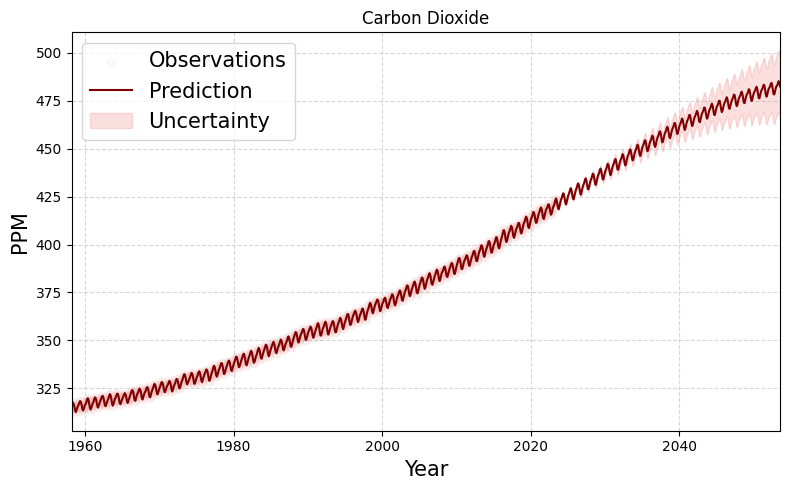

In [47]:
fig = plt.figure(figsize=(8,5))
plt.scatter(X, y, c='lightcoral', alpha=0.05, label='Observations')
plt.plot(points, pred, 'maroon', label='Prediction')
plt.fill_between(points[:,0], pred-std, pred+std, alpha=0.25,
                 color='lightcoral', label='Uncertainty')
plt.xlim(points.min(), points.max())
plt.legend(fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.ylabel("PPM", fontsize=15)
plt.title("Carbon Dioxide")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

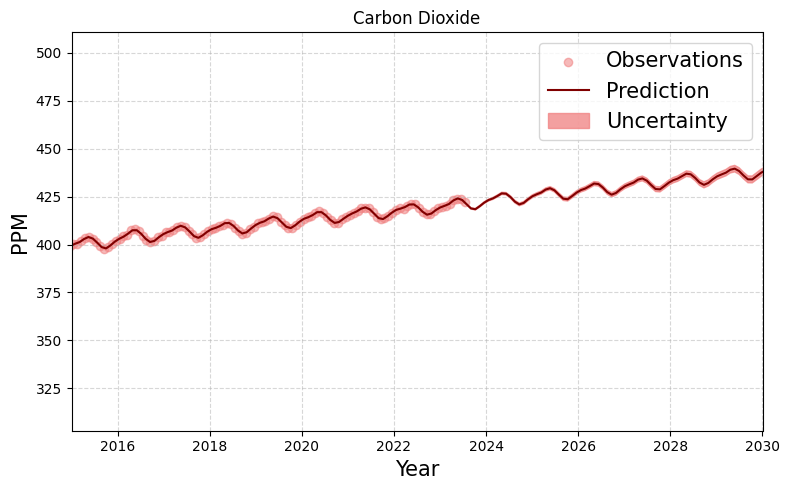

In [48]:
fig = plt.figure(figsize=(8,5))
plt.scatter(X, y, c='lightcoral', alpha=0.55, label='Observations')
plt.plot(points, pred, 'maroon', label='Prediction')
plt.fill_between(points[:,0], pred-std, pred+std, alpha=0.75,
                 color='lightcoral', label='Uncertainty')
plt.xlim(2015, 2030)
plt.legend(fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.ylabel("PPM", fontsize=15)
plt.title("Carbon Dioxide")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### CH4

In [49]:
path = 'Inputs/'
data = pd.read_csv(path + 'ch4_mm_gl.txt', header=0, delimiter='\s+')

In [50]:
summarize_columns(data)

,col_name,dtypes,missing,missing_percent,uniques,first_value,second_value,third_value
0,year,int64,0,0.0,41,1983.000,1983.000,1983.000
1,month,int64,0,0.0,12,7.000,8.000,9.000
2,decimal,float64,0,0.0,478,1983.542,1983.625,1983.708
3,average,float64,0,0.0,473,1626.090,1628.010,1638.420
4,average_unc,float64,0,0.0,108,2.100,2.690,2.330
5,trend,float64,0,0.0,471,1635.070,1635.620,1636.220
6,trennd_unc,float64,0,0.0,60,1.390,1.330,1.270


In [51]:
X = np.array(data['decimal']).reshape(-1,1)
y = np.array(data['average'])

In [52]:
k1 = 2.0**2 * RBF(length_scale=100.0) *\
     ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds='fixed')
k2 = 0.1**2 * RBF(length_scale=0.1) +\
     WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5))
k3 = 2.0**2 * RBF(length_scale=1.0) *\
     ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds='fixed')

kernel = k1 + k2 + k3
gp = GaussianProcessRegressor(kernel=kernel, alpha=0, normalize_y=True)
gp.fit(X, y)
log_marg_likelihood = gp.log_marginal_likelihood(gp.kernel_.theta)
print("\n--- Gaussian Process Model ---")
print(f"Initial Kernel Structure:\n{k1} + \n{k2} + \n{k3} + \n{k4}\n")
print(f"Optimized Kernel After Fitting:\n{gp.kernel_}\n")
print(f"Log-Marginal-Likelihood: {log_marg_likelihood:.3f}")
print("\n--- Optimized Hyperparameters ---")
for param, value in zip(gp.kernel_.hyperparameters, gp.kernel_.theta):
    print(f"{param.name}: {value:.6f}")


--- Gaussian Process Model ---
Initial Kernel Structure:
2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 
0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01) + 
2**2 * RBF(length_scale=1) * ExpSineSquared(length_scale=1, periodicity=1) + 
0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

Optimized Kernel After Fitting:
3.29**2 * RBF(length_scale=101) * ExpSineSquared(length_scale=3.77, periodicity=1) + 0.0255**2 * RBF(length_scale=0.113) + WhiteKernel(noise_level=1e-05) + 0.236**2 * RBF(length_scale=2.03) * ExpSineSquared(length_scale=1.75e+04, periodicity=1)

Log-Marginal-Likelihood: 1308.234

--- Optimized Hyperparameters ---
k1__k1__k1__k1__constant_value: 2.379662
k1__k1__k1__k2__length_scale: 4.619509
k1__k1__k2__length_scale: 1.327387
k1__k1__k2__periodicity: -7.336730
k1__k2__k1__k1__constant_value: -2.180338
k1__k2__k1__k2__length_scale: -11.512925
k1__k2__k2__noise_level: -2.884545
k2__k1__k1__constant_value: 0.707207
k2

In [53]:
n = 1000
margin = 30
points = np.linspace(X.min(), X.max() + margin, n).reshape(-1, 1)
pred, std = gp.predict(points, return_std=True)

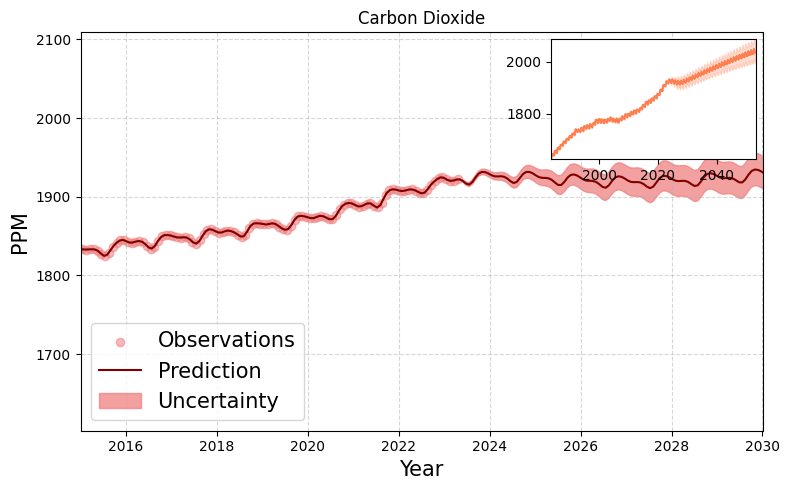

In [54]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X, y, c='lightcoral', alpha=0.55, label='Observations')
ax.plot(points, pred, 'maroon', label='Prediction')
ax.fill_between(points[:, 0], pred - std, pred + std, alpha=0.75,
                color='lightcoral', label='Uncertainty')
ax.set_xlim(2015, 2030)
ax.legend(fontsize=15, loc='lower left')
ax.set_xlabel("Year", fontsize=15)
ax.set_ylabel("PPM", fontsize=15)
ax.set_title("Carbon Dioxide")
ax.grid(True, linestyle='--', alpha=0.5)

ax_inset = inset_axes(ax, width="30%", height="30%", loc='upper right')
ax_inset.plot(points, pred, 'coral', label='Prediction (Inset)')
ax_inset.fill_between(points[:, 0], pred - std, pred + std, alpha=0.25, color='coral')
ax_inset.set_xlim(points.min(), points.max())
ax_inset.set_ylim(min(pred - std), max(pred + std))
plt.tight_layout()
plt.show()

### N2O

In [55]:
path = 'Inputs/'
data = pd.read_csv(path + 'n2o_mm_gl.txt', header=0, delimiter='\s+')

In [56]:
summarize_columns(data)

,col_name,dtypes,missing,missing_percent,uniques,first_value,second_value,third_value
0,year,int64,0,0.0,23,2001.000,2001.000,2001.000
1,month,int64,0,0.0,12,1.000,2.000,3.000
2,decimal,float64,0,0.0,268,2001.042,2001.125,2001.208
3,average,float64,0,0.0,243,316.300,316.310,316.210
4,average_unc,float64,0,0.0,9,0.170,0.180,0.170
5,trend,float64,0,0.0,268,316.030,316.090,316.150
6,trennd_unc,float64,0,0.0,7,0.160,0.160,0.160


In [57]:
X = np.array(data['decimal']).reshape(-1,1)
y = np.array(data['average'])

In [58]:
k1 = 50.0 * RBF(length_scale=50.0)  # high amplitude, long length scale RBF for smooth trends
k2 = (2.0**2 * RBF(length_scale=100.0) *
      ExpSineSquared(length_scale=1.0,
                     periodicity=1.0,
                     periodicity_bounds='fixed'))  # long-term periodic kernel
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)  # rational quadratic for medium-scale variations
k4 = (0.1**2 * RBF(length_scale=0.1) +
      WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-5, np.inf)))  # small-scale noise and noise kernel
kernel = k1 + k2 + k3 + k4
gp = GaussianProcessRegressor(kernel=kernel, alpha=0, normalize_y=True)
gp.fit(X, y)
log_marg_likelihood = gp.log_marginal_likelihood(gp.kernel_.theta)
print("\n--- Gaussian Process Model ---")
print(f"Initial Kernel Structure:\n{k1} + \n{k2} + \n{k3} + \n{k4}\n")
print(f"Optimized Kernel After Fitting:\n{gp.kernel_}\n")
print(f"Log-Marginal-Likelihood: {log_marg_likelihood:.3f}")
print("\n--- Optimized Hyperparameters ---")
for param, value in zip(gp.kernel_.hyperparameters, gp.kernel_.theta):
    print(f"{param.name}: {value:.6f}")


--- Gaussian Process Model ---
Initial Kernel Structure:
7.07**2 * RBF(length_scale=50) + 
2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 
0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 
0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

Optimized Kernel After Fitting:
5.99**2 * RBF(length_scale=48.2) + 0.0705**2 * RBF(length_scale=844) * ExpSineSquared(length_scale=3.44, periodicity=1) + 0.0974**2 * RationalQuadratic(alpha=0.0216, length_scale=1.79) + 0.0106**2 * RBF(length_scale=0.145) + WhiteKernel(noise_level=1e-05)

Log-Marginal-Likelihood: 945.362

--- Optimized Hyperparameters ---
k1__k1__k1__k1__constant_value: 3.579019
k1__k1__k1__k2__length_scale: 3.874939
k1__k1__k2__k1__k1__constant_value: -5.304976
k1__k1__k2__k1__k2__length_scale: 6.738183
k1__k1__k2__k2__length_scale: 1.234224
k1__k1__k2__k2__periodicity: -4.657715
k1__k2__k1__constant_value: -3.834669
k1__k2__k2__alpha: 0.583446
k1__k2__k2__length_scale: -9.099139
k2_

In [59]:
n = 1000
margin = 30
points = np.linspace(X.min(), X.max() + margin, n).reshape(-1, 1)
pred, std = gp.predict(points, return_std=True)

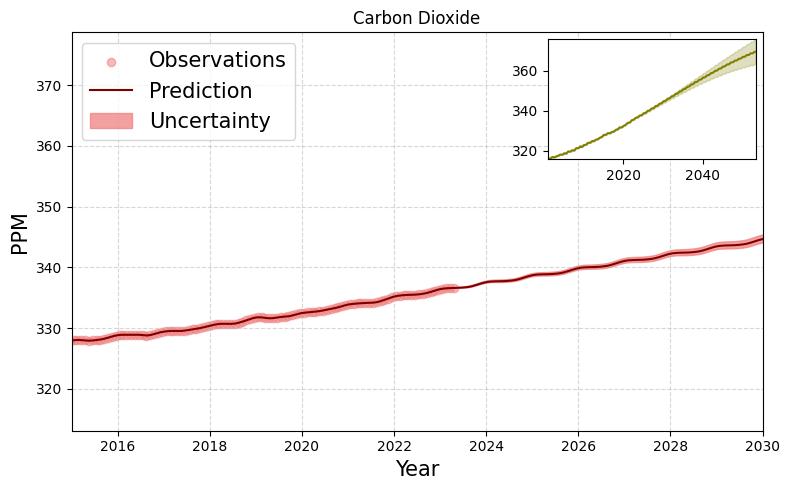

In [60]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X, y, c='lightcoral', alpha=0.55, label='Observations')
ax.plot(points, pred, 'maroon', label='Prediction')
ax.fill_between(points[:, 0], pred - std, pred + std, alpha=0.75,
                color='lightcoral', label='Uncertainty')
ax.set_xlim(2015, 2030)
ax.legend(fontsize=15, loc='upper left')
ax.set_xlabel("Year", fontsize=15)
ax.set_ylabel("PPM", fontsize=15)
ax.set_title("Carbon Dioxide")
ax.grid(True, linestyle='--', alpha=0.5)

ax_inset = inset_axes(ax, width="30%", height="30%", loc='upper right')
ax_inset.plot(points, pred, 'olive', label='Prediction (Inset)')
ax_inset.fill_between(points[:, 0], pred - std, pred + std, alpha=0.25, color='olive')
ax_inset.set_xlim(points.min(), points.max())
ax_inset.set_ylim(min(pred - std), max(pred + std))
plt.tight_layout()
plt.show()